In [4]:
import os, sys, argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
#import logging
#import allel


#current_dir = os.path.dirname(__file__)
current_dir = os.getcwd()
lib_path = os.path.join(current_dir, 'lib')
sys.path.append(lib_path)

print("Using library path:", lib_path)

import vcfReadAndParse
import Fst_diploids
#import initialize_calculation_DataFrame
import parameter_estimate_on_neutral_FST_distribution
#import calculate_pvalue_forAllLoci
import ld
import gnn

Using library path: /mnt/box/myscripts/pyFLANK/lib


/home/zhihai/anaconda3/envs/pyflank/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
os.chdir(f"{current_dir}/data")

"Import" model
Input vcf and pop info

In [17]:
vcf_file_path = "./import/sim1a.vcf.gz"
pop = pd.read_csv("./import/pop1.txt", sep='\\s+', usecols = [1], skiprows = 1, header = None)

Read and extract the genotype

In [18]:
position_info, genotype_info = vcfReadAndParse.read_vcf_file(vcf_file_path)

#format conversion
binary_data = vcfReadAndParse.process_genotype(genotype_info)

G_matrix = pd.DataFrame(binary_data).astype(int)

Calculate raw FST

In [19]:
fst1 = []
for i in range(len(G_matrix)):

    fst1_line = Fst_diploids.get_fsts_diploids(pop, G_matrix.iloc[i].T)
    chrom, pos = position_info[i]
    fst1.append({"CHROM": chrom, "POS": pos, **fst1_line})
    
fst1_df = pd.DataFrame(fst1)

Check the He and Fst

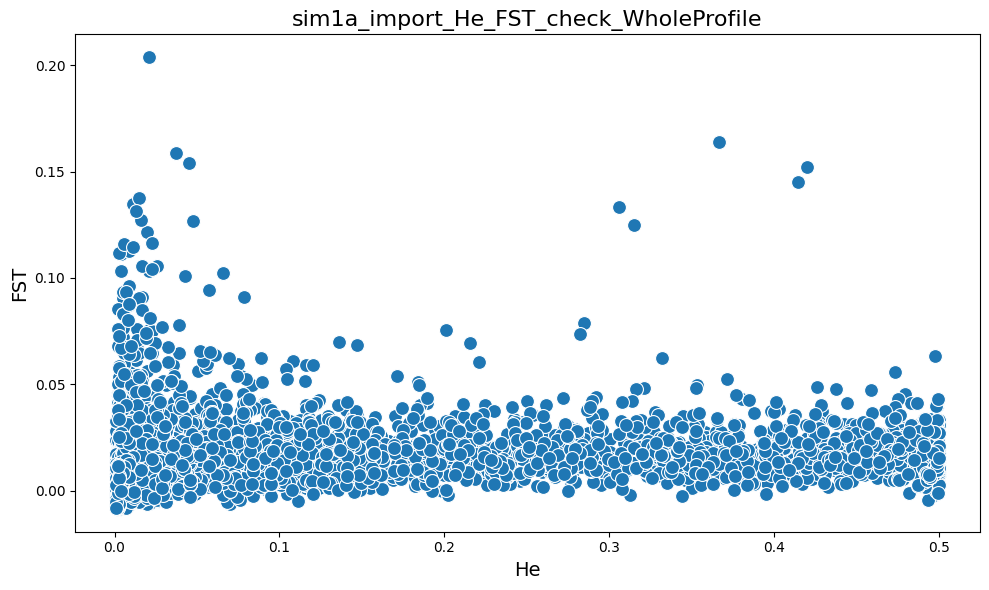

In [20]:
visualization.scatter_plot(f"sim1a_import_He_FST_check_WholeProfile", fst1_df, 'He', 'FST', None, None, 100, None, None, None)

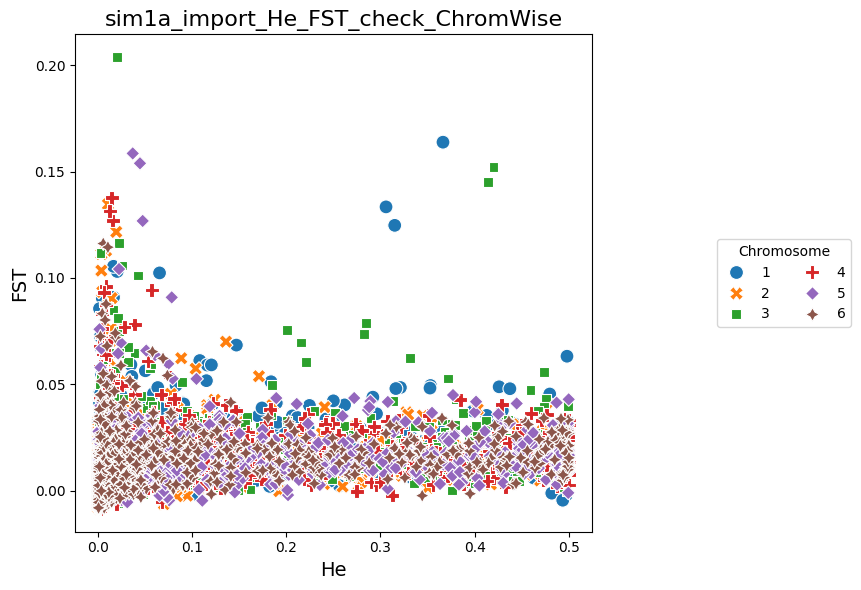

In [25]:
visualization.scatter_plot(f"sim1a_import_He_FST_check_ChromWise", fst1_df, 'He', 'FST', 'CHROM', 'CHROM', 100, legend_title = 'Chromosome', lengend_loc = 'center right', highlight=None)



Check the FST and FSTNoCorr

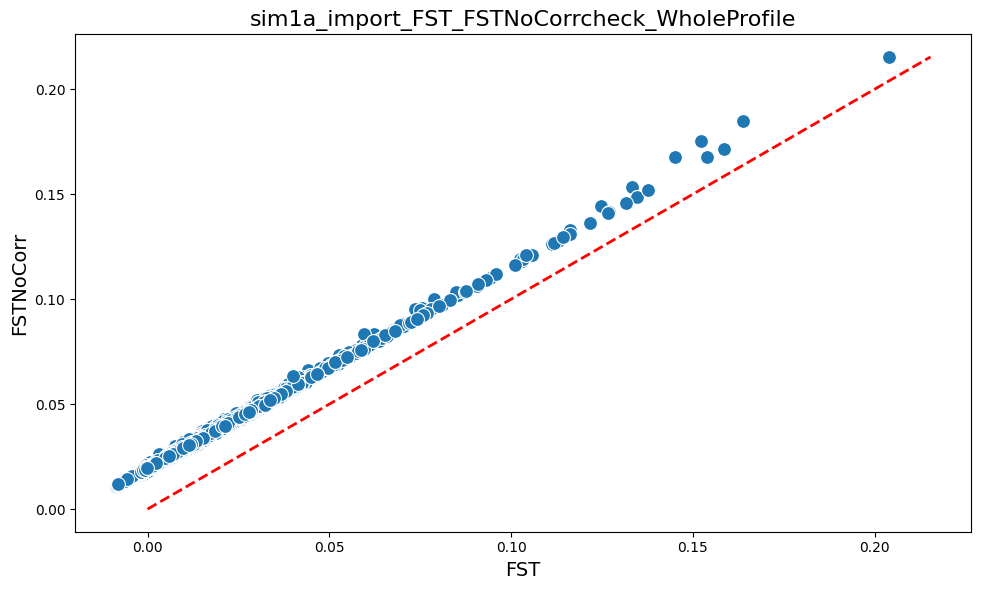

In [26]:
visualization.qq_plot(f"sim1a_import_FST_FSTNoCorrcheck_WholeProfile", fst1_df, 'FST', 'FSTNoCorr', None, None, 100, None, None)

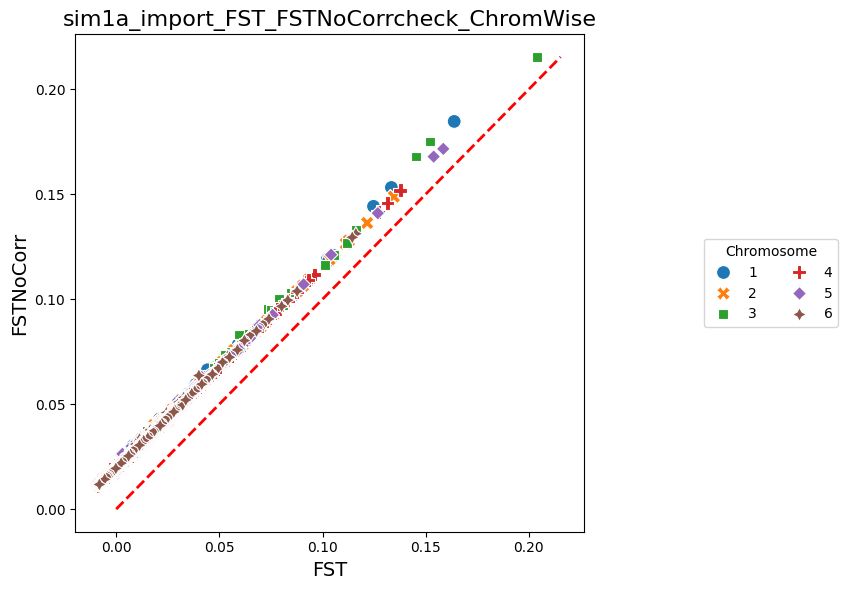

In [30]:
visualization.qq_plot(f"sim1a_import_FST_FSTNoCorrcheck_ChromWise", fst1_df, 'FST', 'FSTNoCorr', 'CHROM', 'CHROM', 100, legend_title = 'Chromosome', lengend_loc = 'center right')

Null fst import

In [31]:
null_vcf_file_path = "./import/which_pruned.vcf.gz"

In [32]:
null_position_info, _ = vcfReadAndParse.read_vcf_file(null_vcf_file_path)

null_pos_df = pd.DataFrame(null_position_info, columns = ['CHROM', 'POS'])

fst1_df['POS'] = fst1_df['POS'].astype(int)
fst1_df['CHROM'] = fst1_df['CHROM'].astype(str)

null_pos_df['POS'] = null_pos_df['POS'].astype(int)
null_pos_df['CHROM'] = null_pos_df['CHROM'].astype(str)

null_fst_df = fst1_df.merge(null_pos_df, on = ['CHROM', 'POS'], how = 'inner')

##initialize calculation dataframe
#estimate the parameters on the neutral FST distribution

In [33]:
NumPopSampled = pop.iloc[:,0].nunique()

null_para = parameter_estimate_on_neutral_FST_distribution.NullCalibration(null_fst_df, left_trim_fraction=0.05, right_trim_fraction=0.05, Hmin=0.1, number_of_samples=NumPopSampled, qthreshold=0.05)

Visualize FST distrubtion of neutral sites and p value histogram

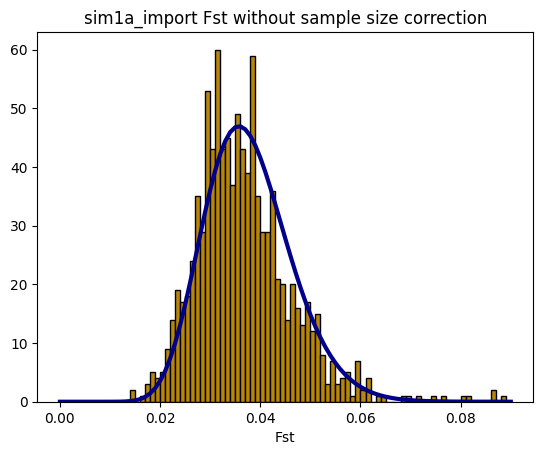

In [ ]:
visualization.OutFLANKResultsPlotter(null_para, withOutliers=True, NoCorr=True, Hmin=0.1, binwidth=0.001, Zoom=False, RightZoomFraction=0.05, titletext = "sim1a_import")

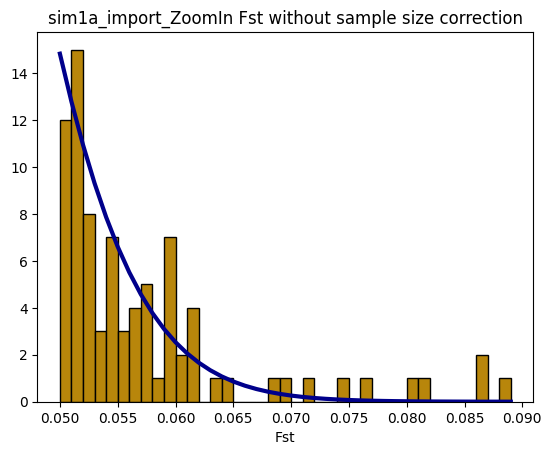

In [37]:
visualization.OutFLANKResultsPlotter(null_para, withOutliers=True, NoCorr=True, Hmin=0.1, binwidth=0.001, Zoom=True, RightZoomFraction=0.05, titletext = "sim1a_import_ZoomIn")

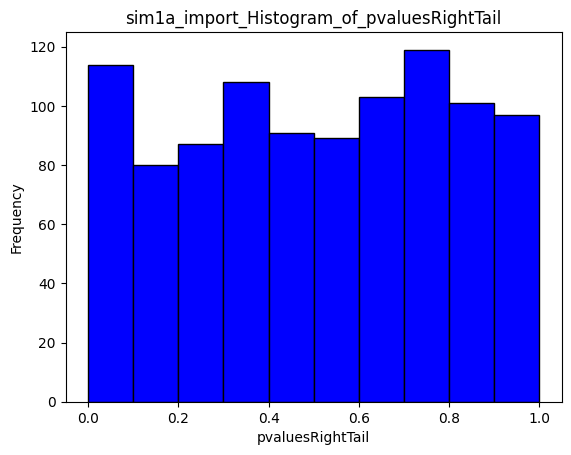

In [38]:
visualization.histgram_plot(null_para['results']['pvaluesRightTail'], 10, titletext = f"sim1a_import_Histogram_of_pvaluesRightTail", x_lab = 'pvaluesRightTail')

Using estimated neutral mean FST and df to calculate P-values for all loci
mulTestCorrect = ["bonferroni" or "fdr"], the default is 'bonferroni'

In [39]:
fst_final = parameter_estimate_on_neutral_FST_distribution.p_outlier_finder_chisq_no_corr(fst1_df, null_para['FSTNoCorrbar'], null_para['dfInferred'], qthreshold=0.05, Hmin=0.1, mulTestCorrect = "bonferroni")


Mark the outliers

In [40]:
fst_final_filtered_outlier = fst_final[fst_final['OutlierFlag'] == True]
fst_final_filtered_He = fst_final[fst_final['He'] > 0.1]

#FST treatment

In [41]:
#convert to numeric
fst_final_filtered_He['FST'] = pd.to_numeric(fst_final_filtered_He['FST'], errors='coerce')

#replace +/- inf with NaN
fst_final_filtered_He['FST'].replace([np.inf, -np.inf], np.nan, inplace=True)

#set negative FST to zero
fst_final_filtered_He.loc[fst_final_filtered_He['FST'] < 0, 'FST'] = 0

#drop rows with NaN / None values in 'FST' column
fst_final_filtered_He = fst_final_filtered_He.dropna(subset=['FST'])

/tmp/ipykernel_26121/1213488004.py:5: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment using an inplace method.
Such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' instead, to perform the operation inplace on the original object, or try to avoid an inplace operation using 'df[col] = df[col].method(value)'.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html
  fst_final_filtered_He['FST'].replace([np.inf, -np.inf], np.nan, inplace=True)


In [42]:
fst_final_filtered_He_outlier = fst_final_filtered_He[fst_final_filtered_He['OutlierFlag'] == True]

#visulation the final results

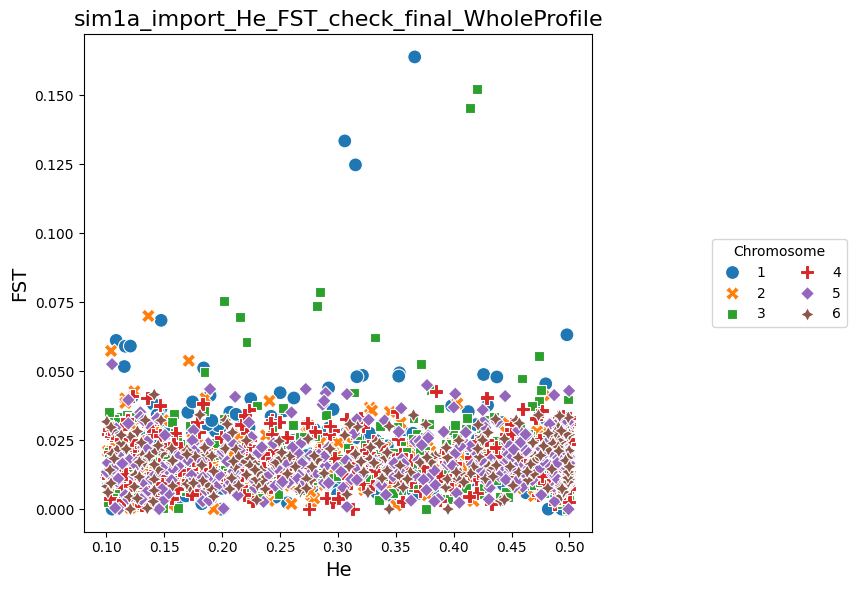

In [43]:
visualization.scatter_plot(f'sim1a_import_He_FST_check_final_WholeProfile', fst_final_filtered_He, 'He', 'FST', 'CHROM', 'CHROM', 100, legend_title = 'Chromosome', lengend_loc = 'center right', highlight = None)

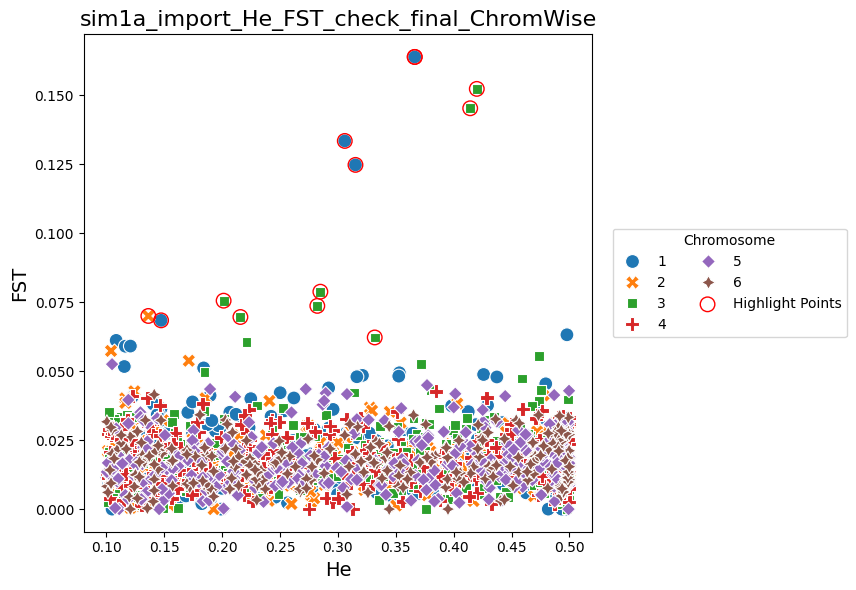

In [ ]:
visualization.scatter_plot(f'sim1a_import_He_FST_check_final_ChromWise', fst_final_filtered_He, 'He', 'FST', 'CHROM', 'CHROM', 100, legend_title = 'Chromosome', lengend_loc = 'center right', highlight = fst_final_filtered_He_outlier)

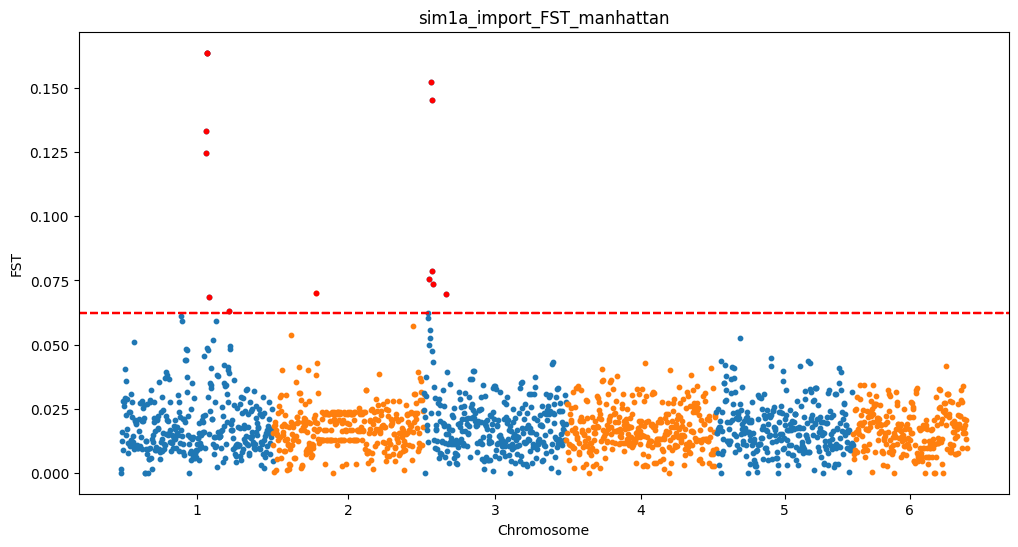

In [45]:
visualization.manhattan_plot(fst_final_filtered_He[['CHROM', 'POS', 'FST', 'qvalues']], 'CHROM', 'POS', 'FST', 'qvalues', threshold=0.05, title=f"sim1a_import_FST_manhattan", LOG = False)


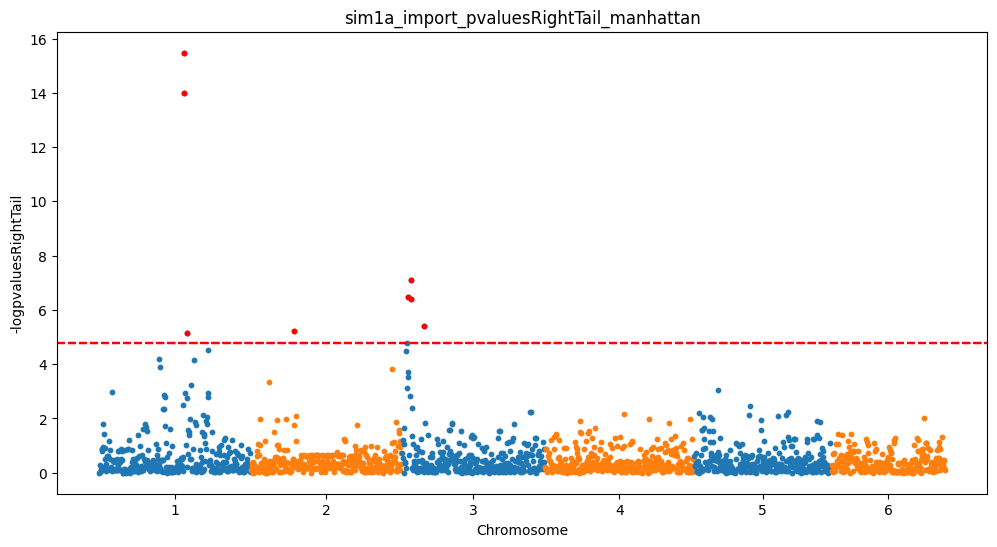

In [46]:
visualization.manhattan_plot(fst_final_filtered_He[['CHROM', 'POS', 'pvaluesRightTail', 'qvalues']], 'CHROM', 'POS', 'pvaluesRightTail', 'qvalues', threshold=0.05, title=f"sim1a_import_pvaluesRightTail_manhattan", LOG = True)

Results save

In [47]:
fst_output1 = fst_final[['CHROM', 'POS', 'He', 'FST', 'T1', 'T2', 'FSTNoCorr', 'T1NoCorr', 'T2NoCorr', 'meanAlleleFreq', 'pvalues', 'pvaluesRightTail', 'qvalues', 'OutlierFlag']]
fst_output1.to_csv(f"sim1a_import_final.csv", sep= '\t', index = False)

fst_output2 = fst_final_filtered_He[['CHROM', 'POS', 'He', 'FST', 'T1', 'T2', 'FSTNoCorr', 'T1NoCorr', 'T2NoCorr', 'meanAlleleFreq', 'pvalues', 'pvaluesRightTail', 'qvalues', 'OutlierFlag']]

fst_output2.to_csv(f"sim1a_import_filtered_He.csv", sep= '\t', index = False)
#fst_output2.to_csv(f"test_filtered_He.csv", sep= '\t', index = False)

fst_output3 = fst_final_filtered_He[['CHROM', 'POS', 'He', 'FST', 'T1', 'T2', 'FSTNoCorr', 'T1NoCorr', 'T2NoCorr', 'meanAlleleFreq', 'pvalues', 'pvaluesRightTail', 'qvalues', 'OutlierFlag']]

fst_output3.to_csv(f"sim1a_import_filtered_Outlier.csv", sep= '\t', index = False)

fst_output4 = fst_final_filtered_He_outlier[['CHROM', 'POS', 'He', 'FST', 'T1', 'T2', 'FSTNoCorr', 'T1NoCorr', 'T2NoCorr', 'meanAlleleFreq', 'pvalues', 'pvaluesRightTail', 'qvalues', 'OutlierFlag']]

fst_output4.to_csv(f"sim1a_import_filtered_He_Outlier.csv", sep= '\t', index = False)

"LD" model
Input vcf and pop info

In [48]:
vcf_file_path = "./ld/sim1a.vcf.gz"
pop = pd.read_csv("./ld/pop1.txt", sep='\\s+', usecols = [1], skiprows = 1, header = None)

Read and extract the genotype

In [49]:
position_info, genotype_info = vcfReadAndParse.read_vcf_file(vcf_file_path)

#format conversion
binary_data = vcfReadAndParse.process_genotype(genotype_info)

G_matrix = pd.DataFrame(binary_data).astype(int)

Calculate raw FST

In [50]:
fst1 = []
for i in range(len(G_matrix)):

    fst1_line = Fst_diploids.get_fsts_diploids(pop, G_matrix.iloc[i].T)
    chrom, pos = position_info[i]
    fst1.append({"CHROM": chrom, "POS": pos, **fst1_line})
    
fst1_df = pd.DataFrame(fst1)

Check the He and Fst

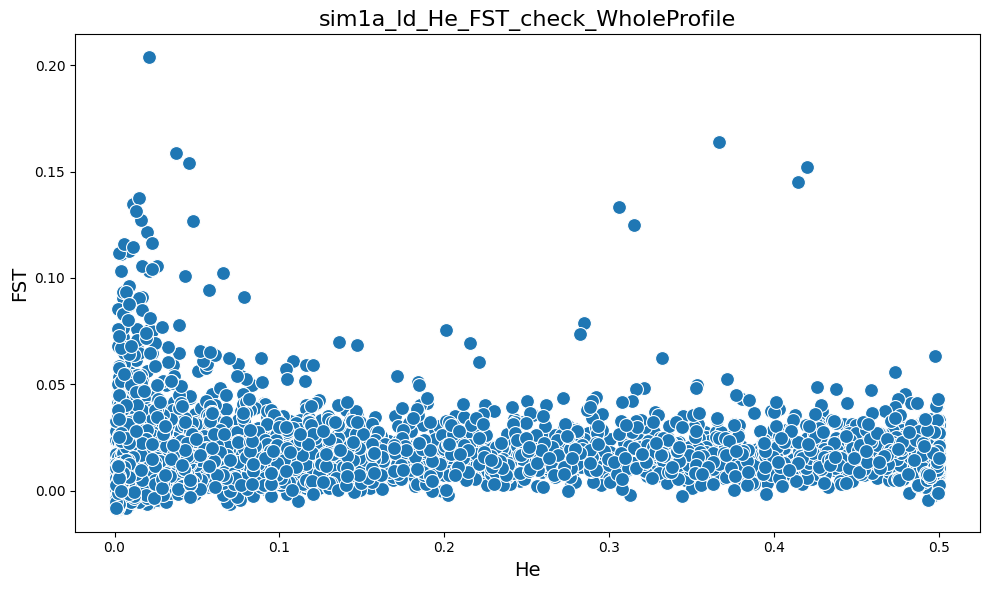

In [51]:
visualization.scatter_plot(f"sim1a_ld_He_FST_check_WholeProfile", fst1_df, 'He', 'FST', None, None, 100, None, None, None)

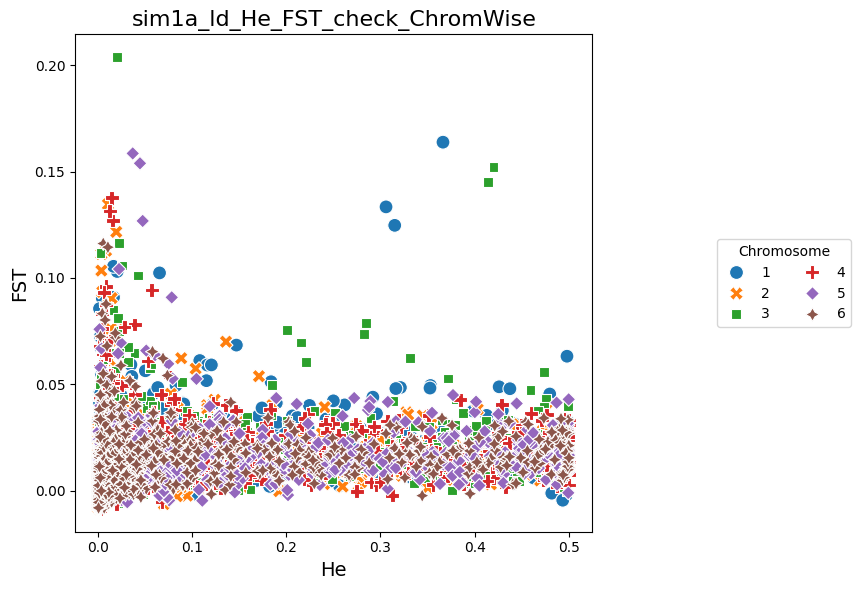

In [52]:
visualization.scatter_plot(f"sim1a_ld_He_FST_check_ChromWise", fst1_df, 'He', 'FST', 'CHROM', 'CHROM', 100, legend_title = 'Chromosome', lengend_loc = 'center right', highlight=None)


check the FST and FSTNoCorr

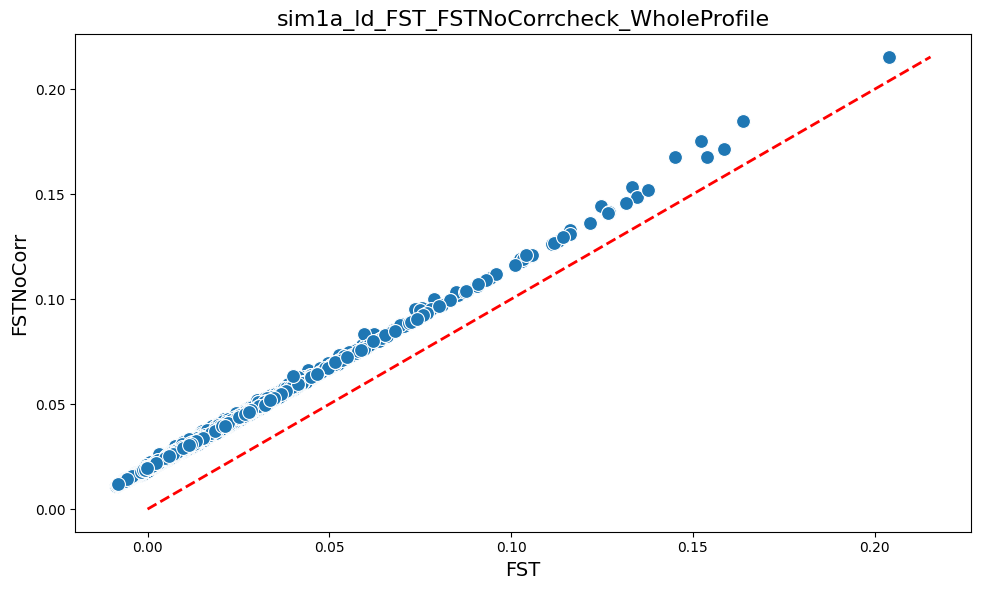

In [53]:
visualization.qq_plot(f"sim1a_ld_FST_FSTNoCorrcheck_WholeProfile", fst1_df, 'FST', 'FSTNoCorr', None, None, 100, None, None)

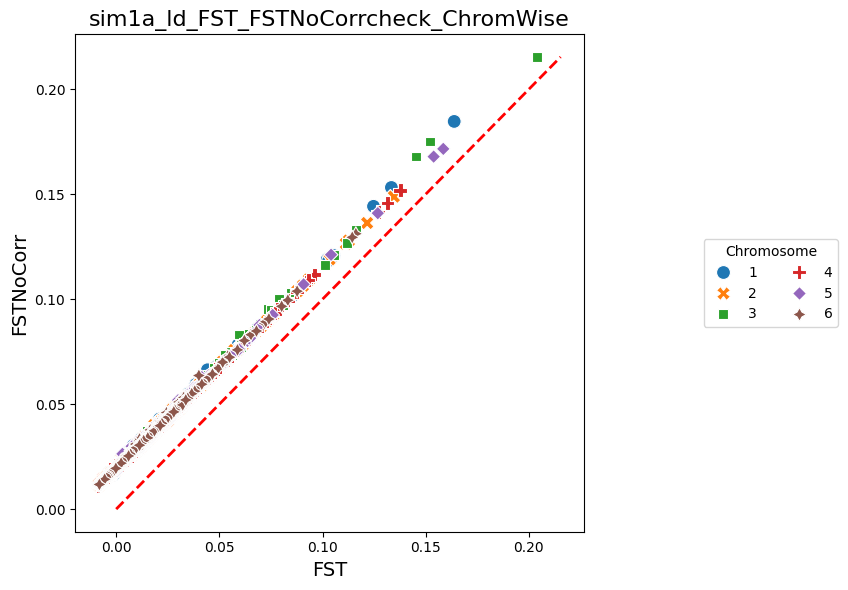

In [54]:
visualization.qq_plot(f"sim1a_ld_FST_FSTNoCorrcheck_ChromWise", fst1_df, 'FST', 'FSTNoCorr', 'CHROM', 'CHROM', 100, legend_title = 'Chromosome', lengend_loc = 'center right')

Null fst infer based on LD model

In [55]:
genotype_matrix = G_matrix.to_numpy()

prune_index = ld.LD_model(genotype_matrix, position_info, ld_window_bp = 10000, ld_threshold = 0.1)

fst1_df['POS'] = fst1_df['POS'].astype(int)
fst1_df['CHROM'] = fst1_df['CHROM'].astype(str)

prune_index['position'] = prune_index['position'].astype(int)
prune_index['chr'] = prune_index['chr'].astype(str)


null_fst_df = fst1_df.merge(prune_index, left_on=['CHROM', 'POS'], right_on=['chr','position'], how = 'inner')
null_fst_df = null_fst_df[null_fst_df["FSTNoCorr"] < 0.1][fst1_df.columns]

Processing variant position: 21
Containing 227 variations within 10-KB span
Processing variant position: 10076
Containing 274 variations within 10-KB span
Processing variant position: 20082
Containing 236 variations within 10-KB span
Processing variant position: 30094
Containing 239 variations within 10-KB span
Processing variant position: 40049
Containing 242 variations within 10-KB span
Processing variant position: 50109
Containing 287 variations within 10-KB span
Processing variant position: 60135
Containing 244 variations within 10-KB span
Processing variant position: 70144
Containing 256 variations within 10-KB span
Processing variant position: 80005
Containing 248 variations within 10-KB span
Processing variant position: 90006
Containing 252 variations within 10-KB span
Processing variant position: 100047
Containing 229 variations within 10-KB span
Processing variant position: 110131
Containing 257 variations within 10-KB span
Processing variant position: 120001
Containing 257 va

##initialize calculation dataframe
#estimate the parameters on the neutral FST distribution

In [56]:
NumPopSampled = pop.iloc[:,0].nunique()

null_para = parameter_estimate_on_neutral_FST_distribution.NullCalibration(null_fst_df, left_trim_fraction=0.05, right_trim_fraction=0.05, Hmin=0.1, number_of_samples=NumPopSampled, qthreshold=0.05)

visualize FST distrubtion of neutral sites and p value histogram

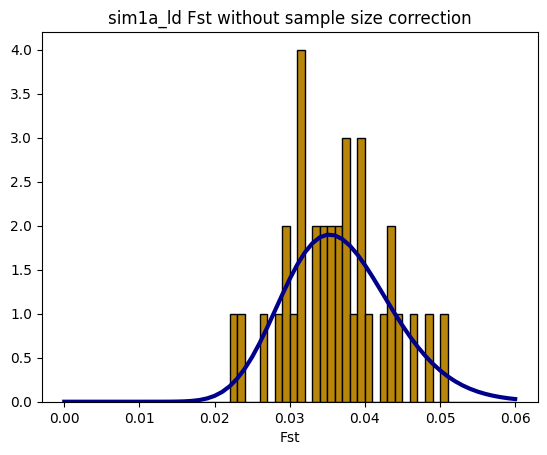

In [58]:
visualization.OutFLANKResultsPlotter(null_para, withOutliers=True, NoCorr=True, Hmin=0.1, binwidth=0.001, Zoom=False, RightZoomFraction=0.05, titletext = "sim1a_ld")

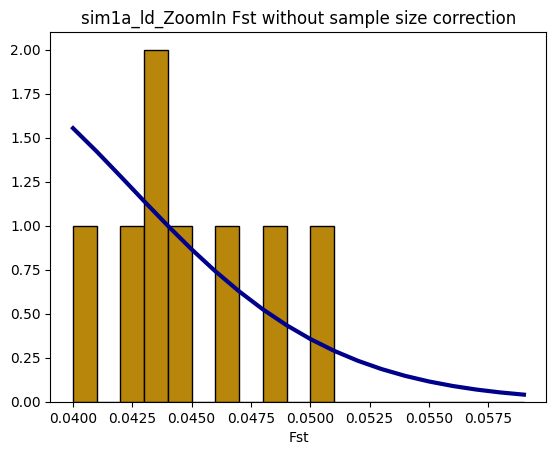

In [59]:
visualization.OutFLANKResultsPlotter(null_para, withOutliers=True, NoCorr=True, Hmin=0.1, binwidth=0.001, Zoom=True, RightZoomFraction=0.05, titletext = "sim1a_ld_ZoomIn")

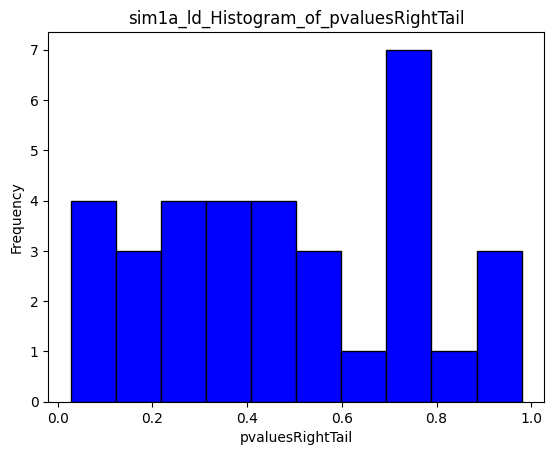

In [60]:
visualization.histgram_plot(null_para['results']['pvaluesRightTail'], 10, titletext = f"sim1a_ld_Histogram_of_pvaluesRightTail", x_lab = 'pvaluesRightTail')

Using estimated neutral mean FST and df to calculate P-values for all loci
mulTestCorrect = ["bonferroni" or "fdr"], the default is 'bonferroni'

In [61]:
fst_final = parameter_estimate_on_neutral_FST_distribution.p_outlier_finder_chisq_no_corr(fst1_df, null_para['FSTNoCorrbar'], null_para['dfInferred'], qthreshold=0.05, Hmin=0.1, mulTestCorrect = "bonferroni")

Mark the outliers

In [62]:
fst_final_filtered_outlier = fst_final[fst_final['OutlierFlag'] == True]
fst_final_filtered_He = fst_final[fst_final['He'] > 0.1]

#FST treatment

In [63]:
#convert to numeric
fst_final_filtered_He['FST'] = pd.to_numeric(fst_final_filtered_He['FST'], errors='coerce')

#replace +/- inf with NaN
fst_final_filtered_He['FST'].replace([np.inf, -np.inf], np.nan, inplace=True)

#set negative FST to zero
fst_final_filtered_He.loc[fst_final_filtered_He['FST'] < 0, 'FST'] = 0

#drop rows with NaN / None values in 'FST' column
fst_final_filtered_He = fst_final_filtered_He.dropna(subset=['FST'])

/tmp/ipykernel_26121/1213488004.py:5: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment using an inplace method.
Such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' instead, to perform the operation inplace on the original object, or try to avoid an inplace operation using 'df[col] = df[col].method(value)'.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html
  fst_final_filtered_He['FST'].replace([np.inf, -np.inf], np.nan, inplace=True)


In [64]:
fst_final_filtered_He_outlier = fst_final_filtered_He[fst_final_filtered_He['OutlierFlag'] == True]

#visulation the final results

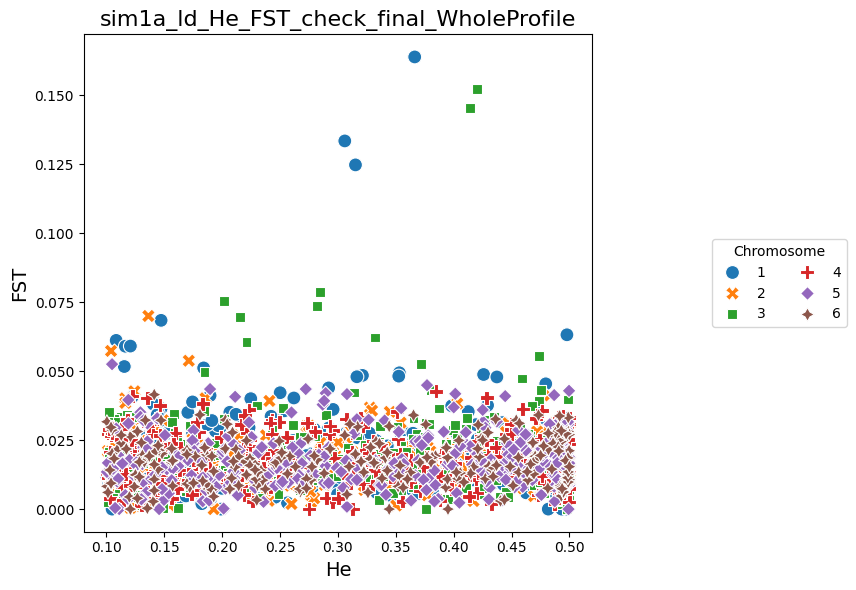

In [65]:
visualization.scatter_plot(f'sim1a_ld_He_FST_check_final_WholeProfile', fst_final_filtered_He, 'He', 'FST', 'CHROM', 'CHROM', 100, legend_title = 'Chromosome', lengend_loc = 'center right', highlight = None)

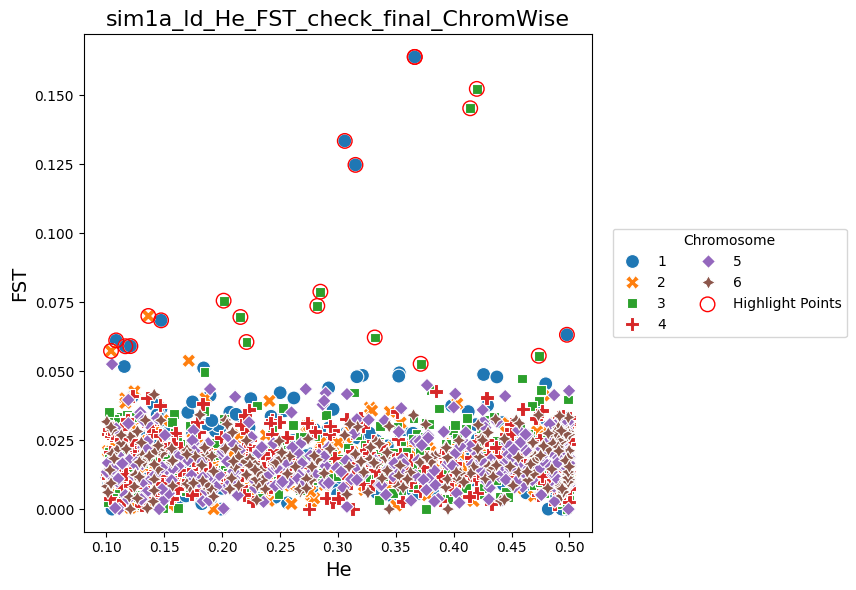

In [66]:
visualization.scatter_plot(f'sim1a_ld_He_FST_check_final_ChromWise', fst_final_filtered_He, 'He', 'FST', 'CHROM', 'CHROM', 100, legend_title = 'Chromosome', lengend_loc = 'center right', highlight = fst_final_filtered_He_outlier)

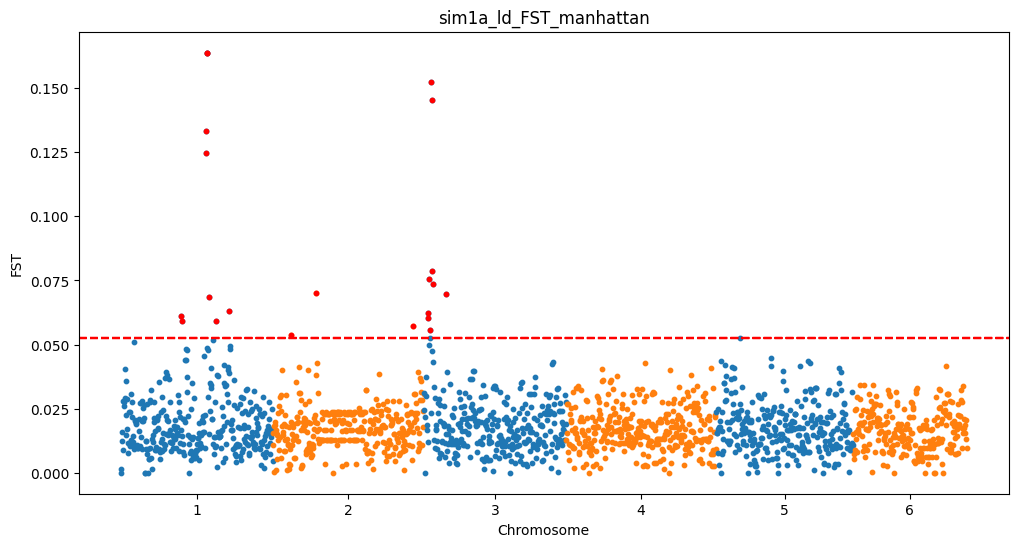

In [67]:
visualization.manhattan_plot(fst_final_filtered_He[['CHROM', 'POS', 'FST', 'qvalues']], 'CHROM', 'POS', 'FST', 'qvalues', threshold=0.05, title=f"sim1a_ld_FST_manhattan", LOG = False)


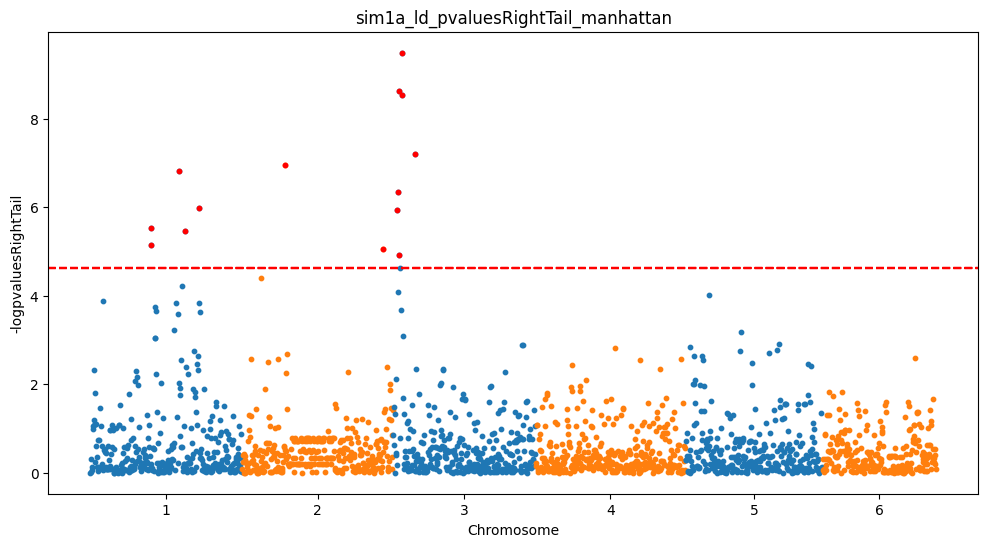

In [68]:
visualization.manhattan_plot(fst_final_filtered_He[['CHROM', 'POS', 'pvaluesRightTail', 'qvalues']], 'CHROM', 'POS', 'pvaluesRightTail', 'qvalues', threshold=0.05, title=f"sim1a_ld_pvaluesRightTail_manhattan", LOG = True)

Results save

In [70]:
fst_output1 = fst_final[['CHROM', 'POS', 'He', 'FST', 'T1', 'T2', 'FSTNoCorr', 'T1NoCorr', 'T2NoCorr', 'meanAlleleFreq', 'pvalues', 'pvaluesRightTail', 'qvalues', 'OutlierFlag']]
fst_output1.to_csv(f"sim1a_ld_final.csv", sep= '\t', index = False)

fst_output2 = fst_final_filtered_He[['CHROM', 'POS', 'He', 'FST', 'T1', 'T2', 'FSTNoCorr', 'T1NoCorr', 'T2NoCorr', 'meanAlleleFreq', 'pvalues', 'pvaluesRightTail', 'qvalues', 'OutlierFlag']]

fst_output2.to_csv(f"sim1a_ld_filtered_He.csv", sep= '\t', index = False)
#fst_output2.to_csv(f"test_filtered_He.csv", sep= '\t', index = False)

fst_output3 = fst_final_filtered_He[['CHROM', 'POS', 'He', 'FST', 'T1', 'T2', 'FSTNoCorr', 'T1NoCorr', 'T2NoCorr', 'meanAlleleFreq', 'pvalues', 'pvaluesRightTail', 'qvalues', 'OutlierFlag']]

fst_output3.to_csv(f"sim1a_ld_filtered_Outlier.csv", sep= '\t', index = False)

fst_output4 = fst_final_filtered_He_outlier[['CHROM', 'POS', 'He', 'FST', 'T1', 'T2', 'FSTNoCorr', 'T1NoCorr', 'T2NoCorr', 'meanAlleleFreq', 'pvalues', 'pvaluesRightTail', 'qvalues', 'OutlierFlag']]

fst_output4.to_csv(f"sim1a_ld_filtered_He_Outlier.csv", sep= '\t', index = False)

"GNN" model
Input vcf and pop info

In [71]:
vcf_file_path = "./gnn/sim1a.vcf.gz"
pop = pd.read_csv("./gnn/pop1.txt", sep='\\s+', usecols = [1], skiprows = 1, header = None)

Read and extract the genotype

In [72]:
position_info, genotype_info = vcfReadAndParse.read_vcf_file(vcf_file_path)

#format conversion
binary_data = vcfReadAndParse.process_genotype(genotype_info)

G_matrix = pd.DataFrame(binary_data).astype(int)

calculate raw FST

In [73]:
fst1 = []
for i in range(len(G_matrix)):

    fst1_line = Fst_diploids.get_fsts_diploids(pop, G_matrix.iloc[i].T)
    chrom, pos = position_info[i]
    fst1.append({"CHROM": chrom, "POS": pos, **fst1_line})
    
fst1_df = pd.DataFrame(fst1)

Check the He and Fst

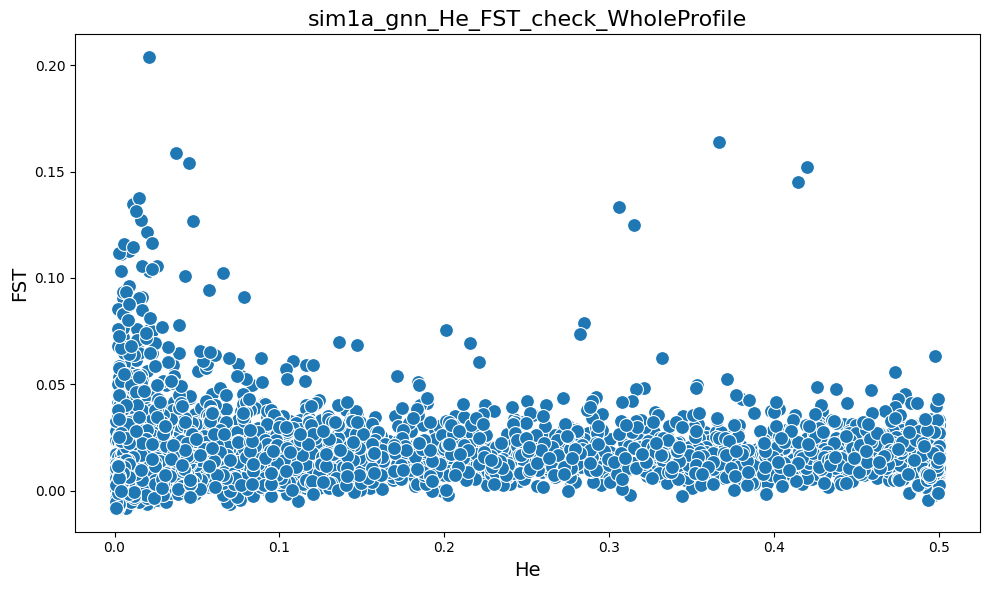

In [74]:
visualization.scatter_plot(f"sim1a_gnn_He_FST_check_WholeProfile", fst1_df, 'He', 'FST', None, None, 100, None, None, None)

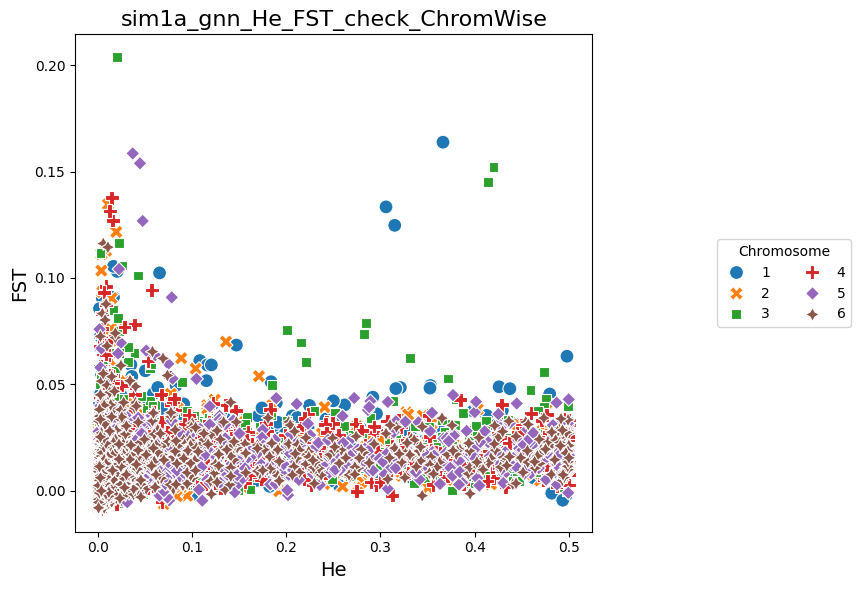

In [75]:
visualization.scatter_plot(f"sim1a_gnn_He_FST_check_ChromWise", fst1_df, 'He', 'FST', 'CHROM', 'CHROM', 100, legend_title = 'Chromosome', lengend_loc = 'center right', highlight=None)


check the FST and FSTNoCorr

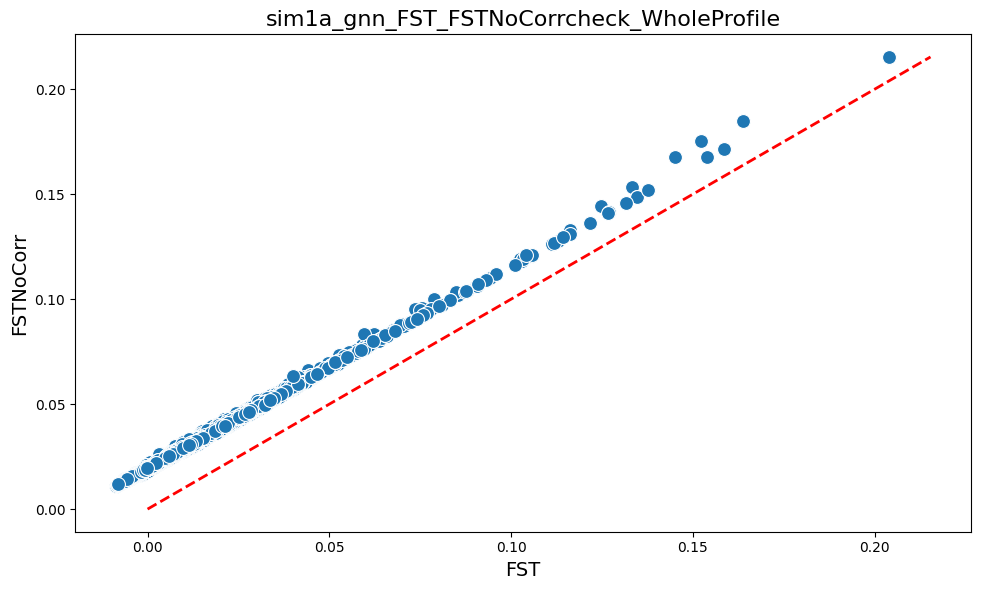

In [76]:
visualization.qq_plot(f"sim1a_gnn_FST_FSTNoCorrcheck_WholeProfile", fst1_df, 'FST', 'FSTNoCorr', None, None, 100, None, None)

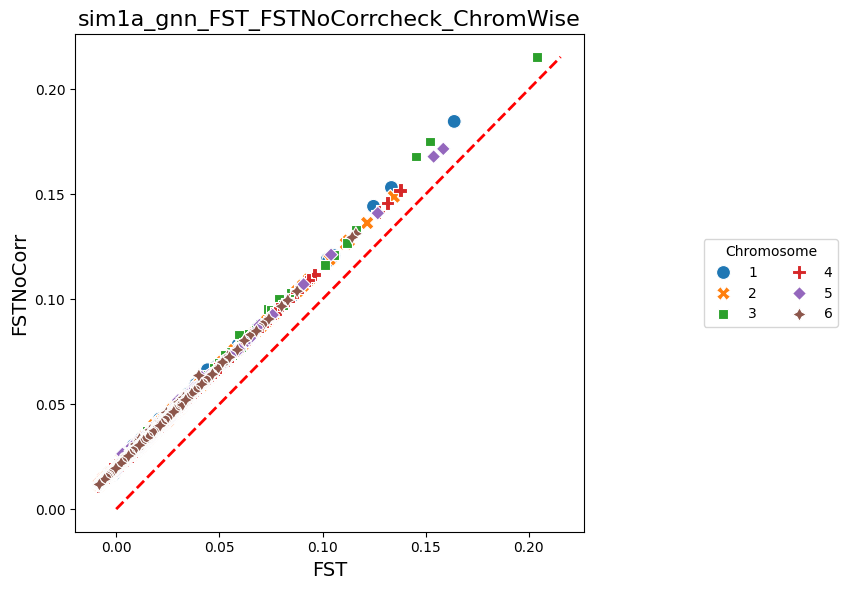

In [77]:
visualization.qq_plot(f"sim1a_gnn_FST_FSTNoCorrcheck_ChromWise", fst1_df, 'FST', 'FSTNoCorr', 'CHROM', 'CHROM', 100, legend_title = 'Chromosome', lengend_loc = 'center right')

Null fst infer based on GNN model

In [78]:
#using deep learning GNN model to infer the null fst df
    
genotype_matrix = G_matrix.to_numpy()

independent_index = gnn.GNN_model(genotype_matrix, position_info, gnn_window_bp = 10000, loss_threshold = 0.1)

fst1_df['POS'] = fst1_df['POS'].astype(int)
fst1_df['CHROM'] = fst1_df['CHROM'].astype(str)

independent_index['POS'] = independent_index['POS'].astype(int)
independent_index['CHROM'] = independent_index['CHROM'].astype(str)

null_fst_df = fst1_df.merge(independent_index, on = ['CHROM', 'POS'], how = 'inner')



#null_fst_df = fst1_df.iloc[independent_genotype_matrix_keep]

null_fst_df = null_fst_df[null_fst_df["FSTNoCorr"] < 0.1]

Processing variant position: 21
Containing 227 variations within 10-KB span
Epoch 1, Loss: 0.502808690071106
Epoch 2, Loss: 0.3090735077857971
Epoch 3, Loss: 0.16551372408866882
Epoch 4, Loss: 0.07215696573257446
Processing variant position: 10076
Containing 274 variations within 10-KB span
Epoch 1, Loss: 4.479866027832031
Epoch 2, Loss: 3.839754343032837
Epoch 3, Loss: 3.272252082824707
Epoch 4, Loss: 2.7641263008117676
Epoch 5, Loss: 2.3138248920440674
Epoch 6, Loss: 1.9145700931549072
Epoch 7, Loss: 1.5693614482879639
Epoch 8, Loss: 1.2771269083023071
Epoch 9, Loss: 1.0295084714889526
Epoch 10, Loss: 0.8208186030387878
Epoch 11, Loss: 0.644263505935669
Epoch 12, Loss: 0.49955156445503235
Epoch 13, Loss: 0.38334521651268005
Epoch 14, Loss: 0.29045772552490234
Epoch 15, Loss: 0.2175064980983734
Epoch 16, Loss: 0.16087332367897034
Epoch 17, Loss: 0.11678382754325867
Epoch 18, Loss: 0.08421193808317184
Processing variant position: 20082
Containing 236 variations within 10-KB span
Epoch 

##initialize calculation dataframe
#estimate the parameters on the neutral FST distribution

In [79]:
NumPopSampled = pop.iloc[:,0].nunique()

null_para = parameter_estimate_on_neutral_FST_distribution.NullCalibration(null_fst_df, left_trim_fraction=0.05, right_trim_fraction=0.05, Hmin=0.1, number_of_samples=NumPopSampled, qthreshold=0.05)

visualize FST distrubtion of neutral sites and p value histogram

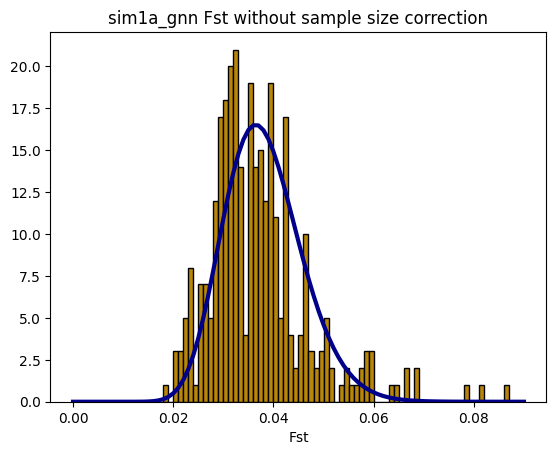

In [80]:
visualization.OutFLANKResultsPlotter(null_para, withOutliers=True, NoCorr=True, Hmin=0.1, binwidth=0.001, Zoom=False, RightZoomFraction=0.05, titletext = "sim1a_gnn")

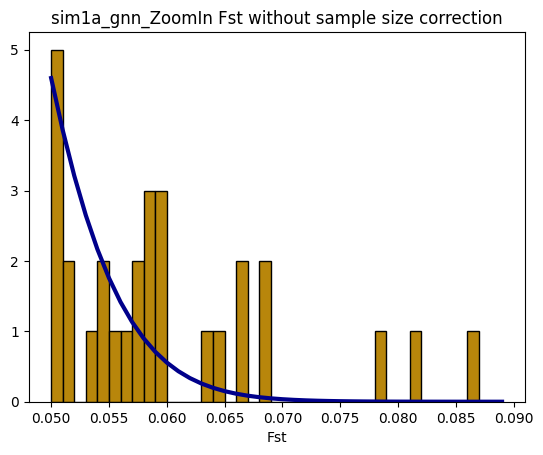

In [81]:
visualization.OutFLANKResultsPlotter(null_para, withOutliers=True, NoCorr=True, Hmin=0.1, binwidth=0.001, Zoom=True, RightZoomFraction=0.05, titletext = "sim1a_gnn_ZoomIn")

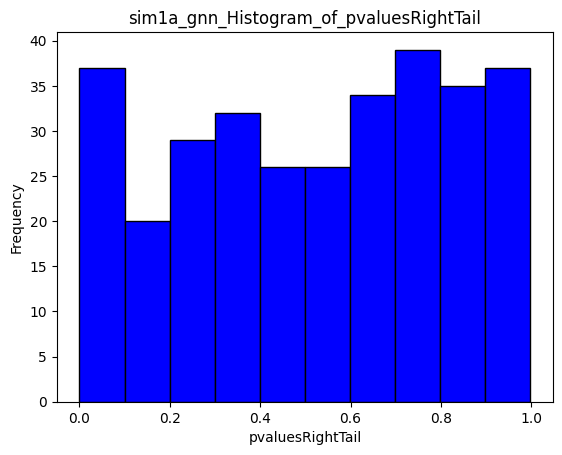

In [82]:
visualization.histgram_plot(null_para['results']['pvaluesRightTail'], 10, titletext = f"sim1a_gnn_Histogram_of_pvaluesRightTail", x_lab = 'pvaluesRightTail')

Using estimated neutral mean FST and df to calculate P-values for all loci
mulTestCorrect = ["bonferroni" or "fdr"], the default is 'bonferroni'

In [83]:
fst_final = parameter_estimate_on_neutral_FST_distribution.p_outlier_finder_chisq_no_corr(fst1_df, null_para['FSTNoCorrbar'], null_para['dfInferred'], qthreshold=0.05, Hmin=0.1, mulTestCorrect = "bonferroni")


Mark the outliers

In [84]:
fst_final_filtered_outlier = fst_final[fst_final['OutlierFlag'] == True]
fst_final_filtered_He = fst_final[fst_final['He'] > 0.1]

FST treatment

In [85]:
#convert to numeric
fst_final_filtered_He['FST'] = pd.to_numeric(fst_final_filtered_He['FST'], errors='coerce')

#replace +/- inf with NaN
fst_final_filtered_He['FST'].replace([np.inf, -np.inf], np.nan, inplace=True)

#set negative FST to zero
fst_final_filtered_He.loc[fst_final_filtered_He['FST'] < 0, 'FST'] = 0

#drop rows with NaN / None values in 'FST' column
fst_final_filtered_He = fst_final_filtered_He.dropna(subset=['FST'])

/tmp/ipykernel_26121/1213488004.py:5: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment using an inplace method.
Such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' instead, to perform the operation inplace on the original object, or try to avoid an inplace operation using 'df[col] = df[col].method(value)'.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html
  fst_final_filtered_He['FST'].replace([np.inf, -np.inf], np.nan, inplace=True)


In [86]:
fst_final_filtered_He_outlier = fst_final_filtered_He[fst_final_filtered_He['OutlierFlag'] == True]

#visulation the final results

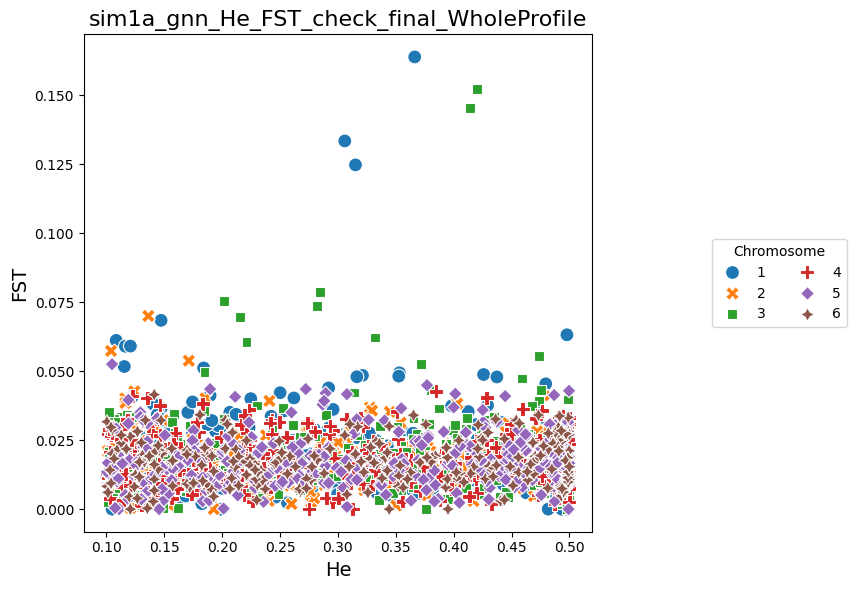

In [87]:
visualization.scatter_plot(f'sim1a_gnn_He_FST_check_final_WholeProfile', fst_final_filtered_He, 'He', 'FST', 'CHROM', 'CHROM', 100, legend_title = 'Chromosome', lengend_loc = 'center right', highlight = None)

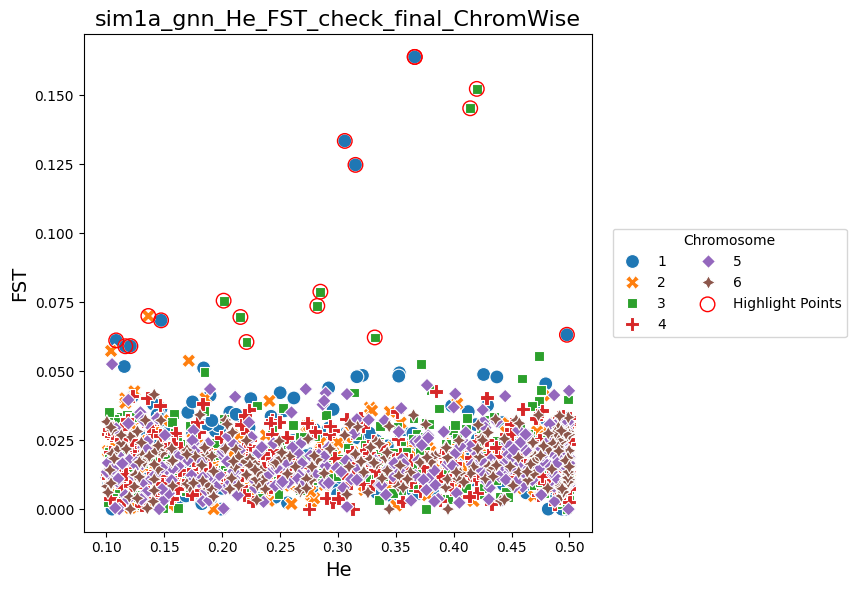

In [88]:
visualization.scatter_plot(f'sim1a_gnn_He_FST_check_final_ChromWise', fst_final_filtered_He, 'He', 'FST', 'CHROM', 'CHROM', 100, legend_title = 'Chromosome', lengend_loc = 'center right', highlight = fst_final_filtered_He_outlier)

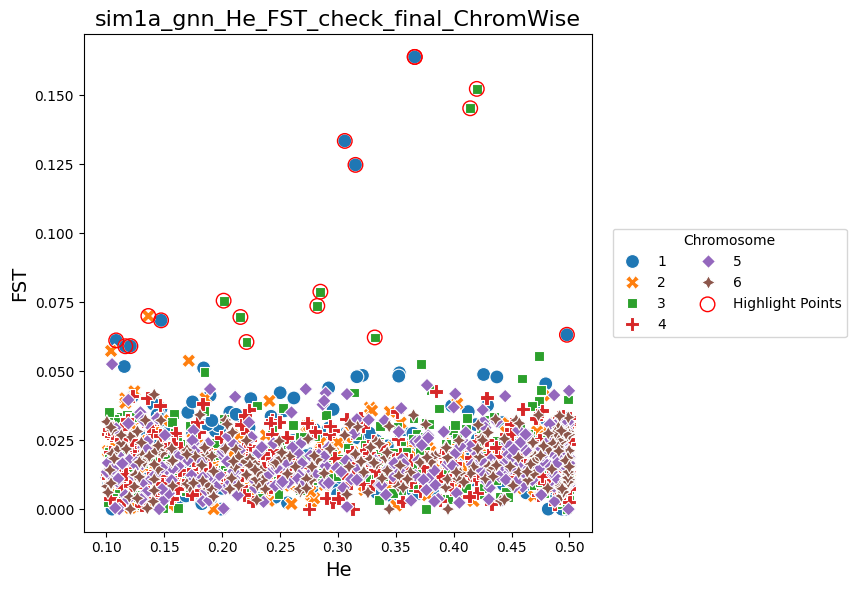

In [89]:
visualization.scatter_plot(f'sim1a_gnn_He_FST_check_final_ChromWise', fst_final_filtered_He, 'He', 'FST', 'CHROM', 'CHROM', 100, legend_title = 'Chromosome', lengend_loc = 'center right', highlight = fst_final_filtered_He_outlier)

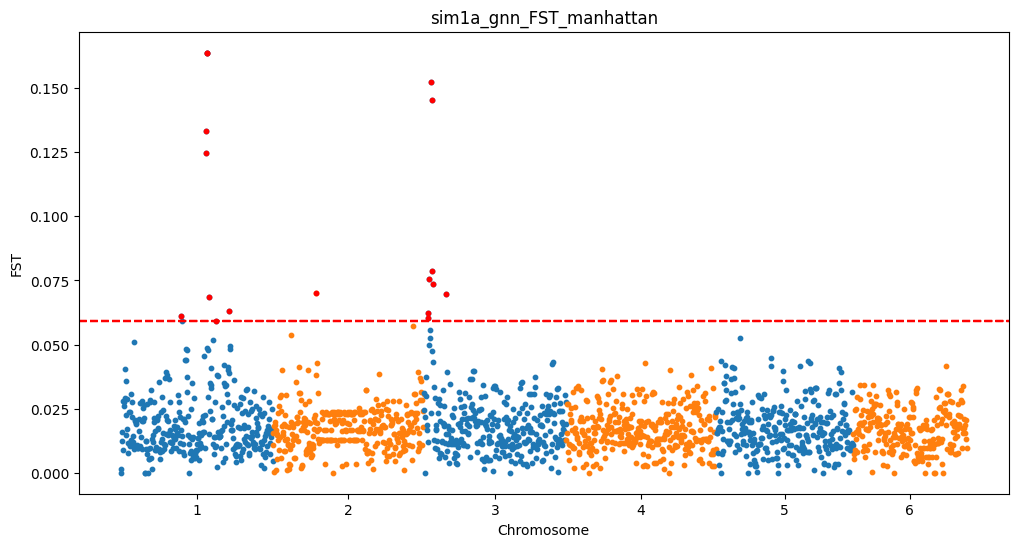

In [90]:
visualization.manhattan_plot(fst_final_filtered_He[['CHROM', 'POS', 'FST', 'qvalues']], 'CHROM', 'POS', 'FST', 'qvalues', threshold=0.05, title=f"sim1a_gnn_FST_manhattan", LOG = False)


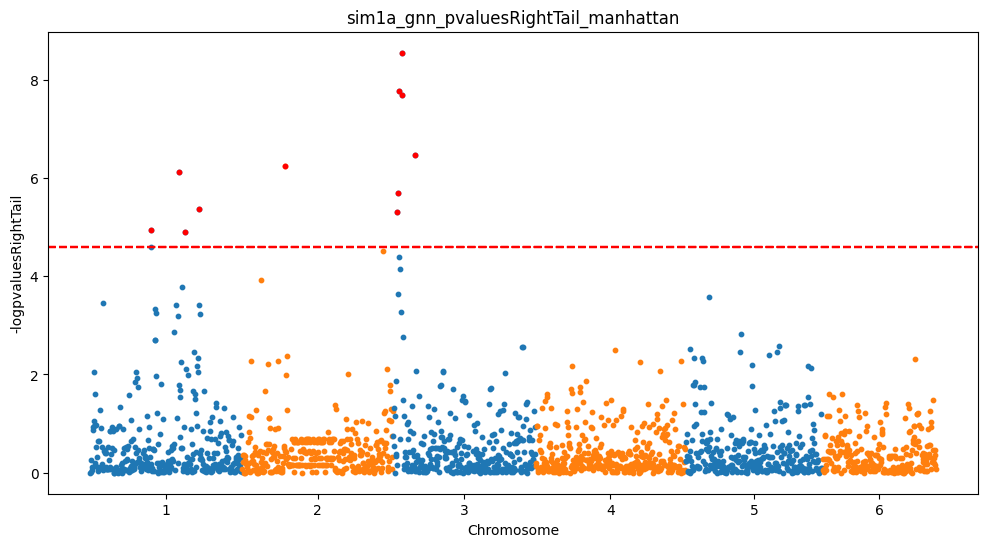

In [91]:
visualization.manhattan_plot(fst_final_filtered_He[['CHROM', 'POS', 'pvaluesRightTail', 'qvalues']], 'CHROM', 'POS', 'pvaluesRightTail', 'qvalues', threshold=0.05, title=f"sim1a_gnn_pvaluesRightTail_manhattan", LOG = True)

Results save

In [92]:
fst_output1 = fst_final[['CHROM', 'POS', 'He', 'FST', 'T1', 'T2', 'FSTNoCorr', 'T1NoCorr', 'T2NoCorr', 'meanAlleleFreq', 'pvalues', 'pvaluesRightTail', 'qvalues', 'OutlierFlag']]
fst_output1.to_csv(f"sim1a_gnn_final.csv", sep= '\t', index = False)

fst_output2 = fst_final_filtered_He[['CHROM', 'POS', 'He', 'FST', 'T1', 'T2', 'FSTNoCorr', 'T1NoCorr', 'T2NoCorr', 'meanAlleleFreq', 'pvalues', 'pvaluesRightTail', 'qvalues', 'OutlierFlag']]

fst_output2.to_csv(f"sim1a_gnn_filtered_He.csv", sep= '\t', index = False)
#fst_output2.to_csv(f"test_filtered_He.csv", sep= '\t', index = False)

fst_output3 = fst_final_filtered_He[['CHROM', 'POS', 'He', 'FST', 'T1', 'T2', 'FSTNoCorr', 'T1NoCorr', 'T2NoCorr', 'meanAlleleFreq', 'pvalues', 'pvaluesRightTail', 'qvalues', 'OutlierFlag']]

fst_output3.to_csv(f"sim1a_gnn_filtered_Outlier.csv", sep= '\t', index = False)

fst_output4 = fst_final_filtered_He_outlier[['CHROM', 'POS', 'He', 'FST', 'T1', 'T2', 'FSTNoCorr', 'T1NoCorr', 'T2NoCorr', 'meanAlleleFreq', 'pvalues', 'pvaluesRightTail', 'qvalues', 'OutlierFlag']]

fst_output4.to_csv(f"sim1a_gnn_filtered_He_Outlier.csv", sep= '\t', index = False)